In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import  yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Input


In [4]:
data = yf.download('SUZLON.NS', start='2010-01-01', end='2024-01-01')
data=data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])
data.head(10)

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,84.016579,84.016579,81.904686,82.501526,82.501526,22576657
1,2010-01-05,82.960632,85.623451,82.960632,84.888878,84.888878,38561060
2,2010-01-06,85.531631,86.266205,84.292046,85.669365,85.669365,32289584
3,2010-01-07,85.990738,85.990738,83.327919,84.429771,84.429771,21782582
4,2010-01-08,84.567505,86.587578,84.567505,85.118439,85.118439,25676237
5,2010-01-11,85.990738,87.413971,85.485718,87.000771,87.000771,29657207
6,2010-01-12,87.322151,87.597610,83.787025,84.567505,84.567505,25142697
7,2010-01-13,84.292046,85.807098,82.409706,85.393898,85.393898,27717641
8,2010-01-14,86.128471,86.266205,83.557472,83.741112,83.741112,19274030
9,2010-01-15,84.200218,84.751152,81.261932,81.812866,81.812866,25493914


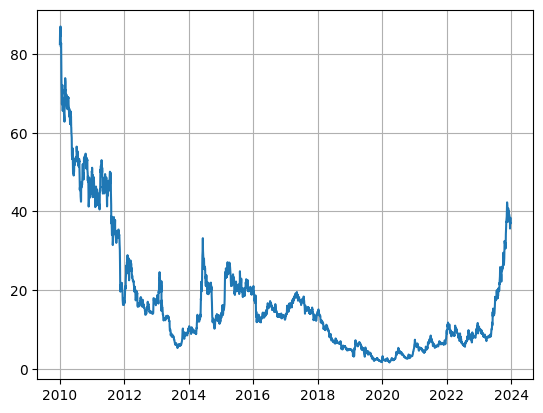

In [5]:
plt.plot(data['Date'] , data['Close'])
plt.grid(True)
plt.show()

In [6]:
imputer = SimpleImputer(strategy="median")
numerical_data= data.select_dtypes(include=[np.number])
imputer.fit(numerical_data)
data.head(10)
imputer.statistics_

array([1.33141022e+01, 1.35895662e+01, 1.29927273e+01, 1.32681913e+01,
       1.32681913e+01, 2.34467790e+07])

In [7]:
data_without_missing_values = imputer.transform(numerical_data)
data_without_missing_values_df = pd.DataFrame(data_without_missing_values,columns = numerical_data.columns)
data_without_missing_values_df['date'] = data['Date']
data_without_missing_values_df

,Open,High,Low,Close,Adj Close,Volume,date
0,84.016579,84.016579,81.904686,82.501526,82.501526,22576657.0,2010-01-04
1,82.960632,85.623451,82.960632,84.888878,84.888878,38561060.0,2010-01-05
2,85.531631,86.266205,84.292046,85.669365,85.669365,32289584.0,2010-01-06
3,85.990738,85.990738,83.327919,84.429771,84.429771,21782582.0,2010-01-07
4,84.567505,86.587578,84.567505,85.118439,85.118439,25676237.0,2010-01-08
...,...,...,...,...,...,...,...
3449,37.500000,38.000000,36.500000,37.250000,37.250000,27363287.0,2023-12-22
3450,37.250000,37.650002,36.549999,36.900002,36.900002,24483621.0,2023-12-26
3451,37.299999,37.299999,36.200001,37.049999,37.049999,29736305.0,2023-12-27
3452,37.200001,38.500000,37.099998,38.150002,38.150002,49428774.0,2023-12-28


In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
scaled_data

array([[0.94731187],
       [0.97526881],
       [0.98440866],
       ...,
       [0.41505455],
       [0.42793606],
       [0.42852157]])

In [9]:
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]

In [10]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(seq_length, len(data)):
        sequences.append(data[i-seq_length:i, 0])
        labels.append(data[i, 0])
    return np.array(sequences), np.array(labels)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [12]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0122
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0012
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 8.0847e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 8.6130e-04
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 6.6422e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 6.4519e-04
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 6.6360e-04
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 5.8156e-04
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 6.5355e-04
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 6.1438e-04
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 5.6818e-04
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 4.6715e-04
Epoch 13/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 5.4915e-04
Epoch 14/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 5.3114e-04
Epoch 15/50
43/43 ━━━━

In [14]:
x_test,y_test = create_sequences(test_data,seq_length)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
x_test

array([[[0.03064516],
        [0.0327957 ],
        [0.03387097],
        ...,
        [0.04193548],
        [0.04086022],
        [0.04139785]],

       [[0.0327957 ],
        [0.03387097],
        [0.03387097],
        ...,
        [0.04086022],
        [0.04139785],
        [0.04247312]],

       [[0.03387097],
        [0.03387097],
        [0.03602151],
        ...,
        [0.04139785],
        [0.04247312],
        [0.04032258]],

       ...,

       [[0.28155555],
        [0.28155555],
        [0.28331211],
        ...,
        [0.41564006],
        [0.41739665],
        [0.41329801]],

       [[0.28155555],
        [0.28331211],
        [0.29677914],
        ...,
        [0.41739665],
        [0.41329801],
        [0.41505455]],

       [[0.28331211],
        [0.29677914],
        [0.31024614],
        ...,
        [0.41329801],
        [0.41505455],
        [0.42793606]]])

In [15]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


C:\Users\Dell\AppData\Local\Temp\ipykernel_7324\2894271941.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


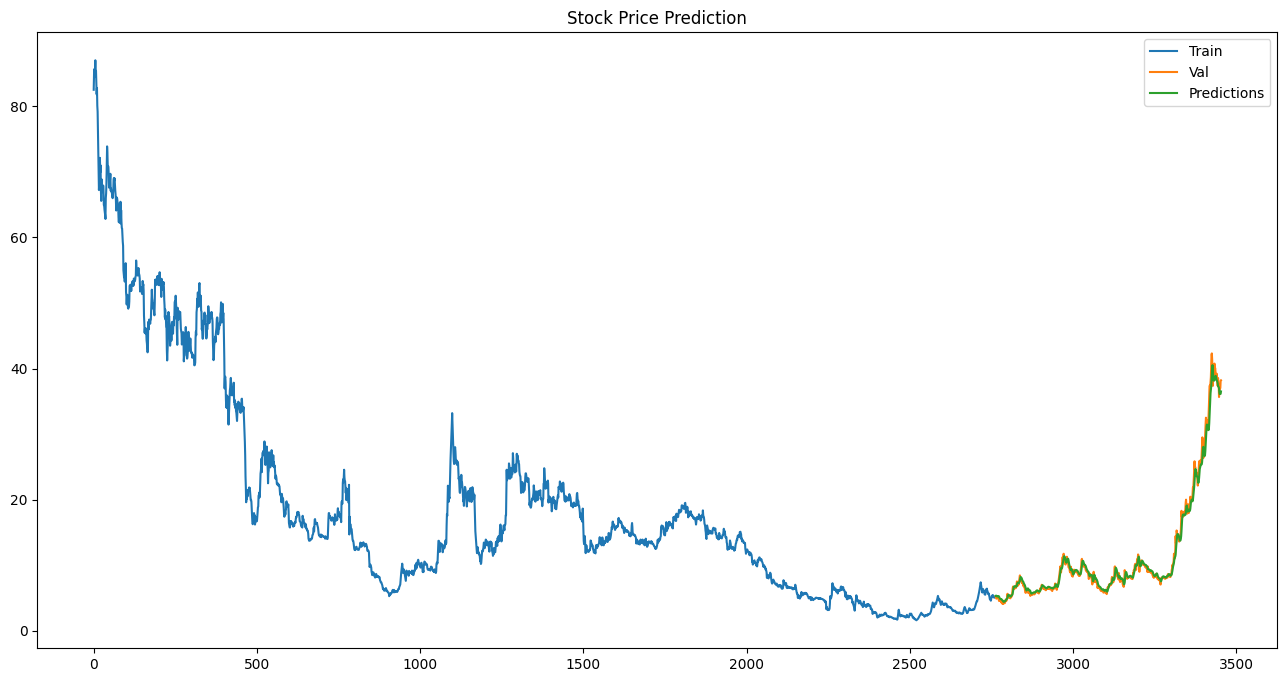

In [16]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Stock Price Prediction')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()

In [17]:
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f"RMSE: {rmse}")

RMSE: 13.957732503234185


In [18]:
relative_rmse = (rmse/np.mean((predictions - y_test) ** 2))*100
relative_rmse

7.164487496577881

In [19]:
model.save('stock_price_lstm_model.keras')